# Quantum Integer Programming (QuIP) 47-779. Fall 2020, CMU

This notebook contains material from the Quantum Integer Programming Lecture at CMU Fall 2020 by David Bernal (bernalde at cmu.edu), Sridhar Tayur (stayur at cmu.edu) and Davide Venturelli; the content is available on **[Github](https://github.com/bernalde/QuIP)**. The text is released under the **[CC-BY-NC-ND-4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode) license, and code is released under the **[MIT license](https://opensource.org/licenses/MIT).*

Run in **[Google Colab](https://colab.research.google.com/github/bernalde/QuIP/blob/master/notebooks/Notebook%205%20-%20QUBO.ipynb)**

## Quadratic Unconstrained Binary Optimization
This notebook will explain the basics of the QUBO modeling. In order to implement the different QUBOs we will use D-Wave's packages **[dimod](https://github.com/dwavesystems/dimod)**, and then solve them using **[neal](https://github.com/dwavesystems/dwave-neal)**'s implementation of simulated annealing.
We will also leverage the use of D-Wave's package **[dwavebinarycsp](https://github.com/dwavesystems/dwavebinarycsp)** to translate constraint satisfaction problems to QUBOs. Finally, for Groebner basis computations we will use **[Sympy](https://www.sympy.org/)** for symbolic computation in Python and **[Networkx](https://networkx.github.io/)** for network models/graphs.

#### Problem statement
We define a QUBO as the following optimization problem:
$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E(G)} Q_{ij}x_i x_j + \sum_{i \in V(G)}Q_{ii}x_i + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$
where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by an adjacency matrix $Q$. We also include an arbitrary offset  $c_Q$.

### Example
Suppose we want to solve the following problem via QUBO
$$
\min_{\mathbf{x}} 2𝑥_0+4𝑥_1+4𝑥_2+4𝑥_3+4𝑥_4+4𝑥_5+5𝑥_6+4𝑥_7+5𝑥_8+6𝑥_9+5𝑥_{10} \\
s.t. \begin{bmatrix}
1 & 0 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 1 & 1\\
0 & 1 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 1\\
0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}\mathbf{x}=
\begin{bmatrix}
1\\
1\\
1
\end{bmatrix} \\
\mathbf{x} \in \{0,1 \}^{11}
$$


In [1]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's install with dimod and neal
if IN_COLAB:
    !pip install dimod
    !pip install dwave-neal

In [2]:
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx

First we would write this problem as a an unconstrained one by penalizing the linear constraints as quadratics in the objective. Let's first define the problem parameters

In [3]:
A = np.array([[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
            [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
            [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]])
b = np.array([1, 1, 1])
c = np.array([2, 4, 4, 4, 4, 4, 5, 4, 5,6, 5])

In order to define the $Q$ matrix, we write the problem
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x}\\
s.t. \mathbf{A}\mathbf{x}=\mathbf{b} \\
\mathbf{x} \in \{0,1 \}^{11}
$$
as follows:
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x} + \rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) \\
\mathbf{x} \in \{0,1 \}^{11}
$$
Exploting the fact that $x^2=x$ for $x \in \{0,1\}$, we can make the linear terms appear in the diagonal of the $Q$ matrix.
$$
\rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) = \rho( \mathbf{x}^\top (\mathbf{A}^\top \mathbf{A}) \mathbf{x} - 2\mathbf{b}^\top \mathbf{A} \mathbf{x} + \mathbf{b}^\top \mathbf{b} )
$$
For this problem in particular, ona can prove the the penalization factor is given by $\rho > \sum_{i=1}^n |c_i|$, therefore we choose this bound + 1.

In [4]:
rho = np.sum(np.abs(c)) + 1
Q = rho*np.matmul(A.T,A)
Q += np.diag(c)
Q -= rho*2*np.diag(np.matmul(b.T,A))
cQ = rho*np.matmul(b.T,b)
print(Q)
print(cQ)


[[ -46    0    0   48   48   48    0   48   48   48   48]
 [   0  -44    0   48    0   48   48    0   48   48   48]
 [   0    0  -44    0   48    0   48   48   48   48   48]
 [  48   48    0  -92   48   96   48   48   96   96   96]
 [  48    0   48   48  -92   48   48   96   96   96   96]
 [  48   48    0   96   48  -92   48   48   96   96   96]
 [   0   48   48   48   48   48  -91   48   96   96   96]
 [  48    0   48   48   96   48   48  -92   96   96   96]
 [  48   48   48   96   96   96   96   96 -139  144  144]
 [  48   48   48   96   96   96   96   96  144 -138  144]
 [  48   48   48   96   96   96   96   96  144  144 -139]]
144


We can visualize the graph that defines this instance using the Q matrix as the adjacency matrix of a graph.

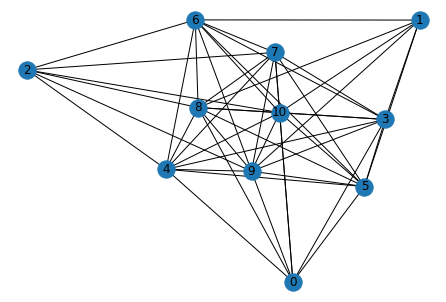

In [5]:
G = nx.from_numpy_matrix(Q)
nx.draw(G, with_labels=True)


Let's define a QUBO model and then solve it via simulated annealing.

In [6]:
model = dimod.BinaryQuadraticModel.from_qubo(Q, offset=cQ)



In [7]:
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]
    
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))


def plot_energies(results, title=None):
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

Let's now solve this problem using Simulated Annealing

In [8]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model, num_reads=1000)


minimum energy: 5.0


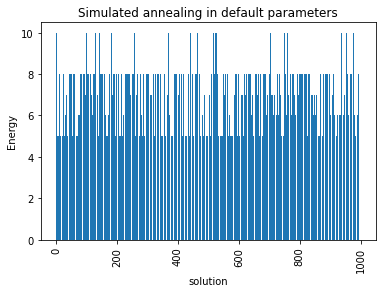

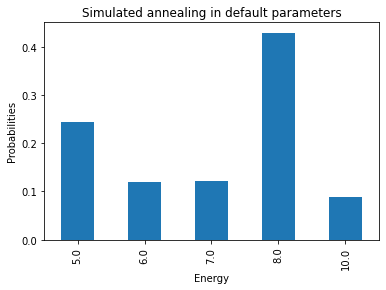

minimum energy: 5.0


In [9]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

Notice that this is the same example we have been solving earlier (via Integer Programming in the Quiz 1 and via Ising model in the Notebook 4).

## Let's go back to the slides

Let's solve the graph coloring problem that we solved via Groebner basis in the Notebook 2 now using QUBO.


$\mathcal{G}(V, E)$ has 12 vertices and 23 edges. We ask if the graph is $3$–colorable. Let’s first encode $V$ and $E$ using Python’s built–in data structures:

This second tutorial is heavily inspired in D-Wave's Map coloring of Canada found **[here](https://docs.ocean.dwavesys.com/en/stable/examples/map_coloring.html)**.

In [10]:
# Let's install with dimod and neal
if IN_COLAB:
    !pip install dwavebinarycsp
    !pip install dwavebinarycsp[maxgap]
    !pip install dwavebinarycsp[mip]

import dwavebinarycsp

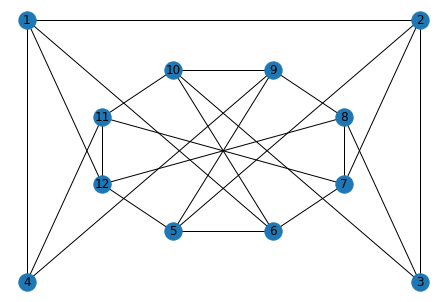

In [11]:
V = range(1, 12+1)
E = [(1,2),(2,3),(1,4),(1,6),(1,12),(2,5),(2,7),(3,8),(3,10),(4,11),(4,9),(5,6),(6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(5,12),(5,9),(6,10),(7,11),(8,12)]
layout = {i: [np.cos((2*i+1)*np.pi/8),np.sin((2*i+1)*np.pi/8)] for i in np.arange(5,13)}
layout[1] = [-1.5,1.5]
layout[2] = [1.5,1.5]
layout[3] = [1.5,-1.5]
layout[4] = [-1.5,-1.5]
G = nx.Graph()
G.add_edges_from(E)
nx.draw(G, with_labels=True, pos=layout)

In [12]:
# Function for the constraint that two nodes with a shared edge not both select
# one color
def not_both_1(v, u):
    return not (v and u)

# Valid configurations for the constraint that each node select a single color, in this case we want to use 3 colors
one_color_configurations = {(0, 0, 1), (0, 1, 0), (1, 0, 0)}
colors = len(one_color_configurations)

# Create a binary constraint satisfaction problem
csp = dwavebinarycsp.ConstraintSatisfactionProblem(dwavebinarycsp.BINARY)

# Add constraint that each node select a single color
for node in V:
    variables = ['x'+str(node)+','+str(i) for i in range(colors)]
    csp.add_constraint(one_color_configurations, variables)

# Add constraint that each pair of nodes with a shared edge not both select one color
for edge in E:
    v, u = edge
    for i in range(colors):
        variables = ['x'+str(v)+','+str(i), 'x'+str(u)+','+str(i)]
        csp.add_constraint(not_both_1, variables)

Defining the Binary Quandratic model (QUBO) using the CSP library we have:

In [13]:
bqm = dwavebinarycsp.stitch(csp)

In [14]:
simAnnSamples = simAnnSampler.sample(bqm, num_reads=1000)


minimum energy: 4.5434708795255574e-07


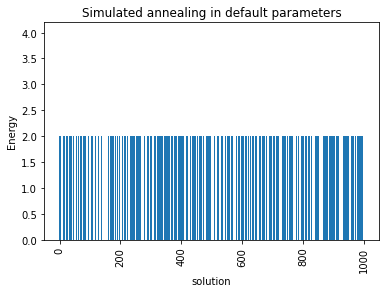

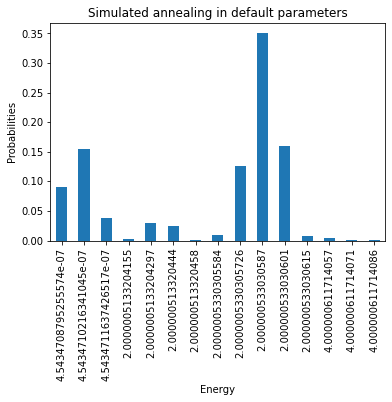

minimum energy: 4.5434708795255574e-07


In [15]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

Because of precision issues in the translation to BQM, we obtain very tiny coefficeints that should be zero. In any case, since this is a constraint satisfaction problem, any of the solutions with energy ~0 is a valid coloring.

In [16]:
# Check that a good solution was found
sample = simAnnSamples.first.sample     # doctest: +SKIP
if not csp.check(sample):           # doctest: +SKIP
        print("Failed to color map. Try sampling again.")
else:
        print(sample)

{'x1,0': 1, 'x1,1': 0, 'x1,2': 0, 'x10,0': 1, 'x10,1': 0, 'x10,2': 0, 'x11,0': 0, 'x11,1': 0, 'x11,2': 1, 'x12,0': 0, 'x12,1': 1, 'x12,2': 0, 'x2,0': 0, 'x2,1': 0, 'x2,2': 1, 'x3,0': 0, 'x3,1': 1, 'x3,2': 0, 'x4,0': 0, 'x4,1': 1, 'x4,2': 0, 'x5,0': 1, 'x5,1': 0, 'x5,2': 0, 'x6,0': 0, 'x6,1': 0, 'x6,2': 1, 'x7,0': 0, 'x7,1': 1, 'x7,2': 0, 'x8,0': 1, 'x8,1': 0, 'x8,2': 0, 'x9,0': 0, 'x9,1': 0, 'x9,2': 1}


In [17]:
# Function that plots a returned sample
def plot_map(sample):
    # Translate from binary to integer color representation
    color_map = {}
    for node in V:
          for i in range(colors):
            if sample['x'+str(node)+','+str(i)]:
                color_map[node] = i
    # Plot the sample with color-coded nodes
    node_colors = [color_map.get(node) for node in G.nodes()]
    nx.draw(G, with_labels=True, pos=layout, node_color=node_colors)
    plt.show()

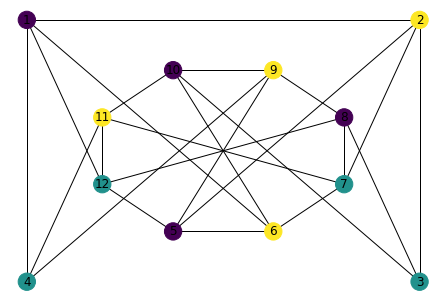

In [18]:
plot_map(sample)

## Let's go back to the slides

This last tutorial implements an example of integer factorization using QUBO. This was published by Rauf Dridi and Hedayat Alghassi (both former postdocs at the CMU Quantum Computing group) in Nature
This notebook is drawn from an implementation found in **[Github](https://github.com/michael-L-i/DWave/blob/master/Factoring.ipynb)**.

The factoring problem: Given a  large number $M$, the gaol is find the two prime factors $p$ and $q$ such that
$$
M = p q.
$$
For instance, if $M=15$ then $p=3$ and $q=5$. To solve this problem on D-Wave (using quantum annealing) we have to map the problem of finding $p$ and $q$ from the integer domain to the binary domain. Let's say, we would like to factor $M=15$. First, we write 
$$
 p = p_0 + 2 p_1 + 4 p_2\, \mbox{and}\, q = q_0 + 2 q_1 + 4 q_2. 
$$
Now the prolem becomes: find the $p_i$ and $q_i$ such that
$$
M = (p_0 + 2 p_1 + 4 p_2) (q_0 + 2 q_1 + 4 q_2).
$$
Let's do the calculations:

In [19]:
from sympy import *
p = IndexedBase("p")
q = IndexedBase("q")

In [20]:
eq = 15 - ((p[0] + 2* p[1] + 4 *p[2]) * (q[0] + 2 *q[1] + 4 *q[2]) )
expand(eq)

-p[0]*q[0] - 2*p[0]*q[1] - 4*p[0]*q[2] - 2*p[1]*q[0] - 4*p[1]*q[1] - 8*p[1]*q[2] - 4*p[2]*q[0] - 8*p[2]*q[1] - 16*p[2]*q[2] + 15

The goal is now to solve $eq =0$. As the title of this section indicates, it is possible to solve this algebraically {\it without a quantum computer} (but not efficiently). Let's explain how this before we move ahead with quantum annealing: Let's state the problem one more time:

Find $p_i$s and $q_i$s such that:

*   $eq=0$ where $eq$ is given in the above cell
*   all $p_i$s and $q_i$s are binary: 
$p_i (p_i-1)=0$ and $q_i (q_i-1)=0$. So we ended up with a set of algebraic equations
$$
  \mathcal S = \{eq=0, p_0 (p_0-1)=0,p_1 (p_1-1)=0,p_2 (p_2-1)=0, q_0 (q_0-1)=0, q_1 (q_1-1)=0, q_2 (q_2-1)=0 \}.
$$
This system can be constructed as follows: 

In [21]:
S = [expand(eq)]
for i in range(3):
  S += [p[i]*(p[i]-1), q[i]*(q[i]-1)]
S

[-p[0]*q[0] - 2*p[0]*q[1] - 4*p[0]*q[2] - 2*p[1]*q[0] - 4*p[1]*q[1] - 8*p[1]*q[2] - 4*p[2]*q[0] - 8*p[2]*q[1] - 16*p[2]*q[2] + 15,
 (p[0] - 1)*p[0],
 (q[0] - 1)*q[0],
 (p[1] - 1)*p[1],
 (q[1] - 1)*q[1],
 (p[2] - 1)*p[2],
 (q[2] - 1)*q[2]]

To solve the system $\mathcal S$ we use Groebner bases technique:

In [22]:
groebner(S, p[0], p[1], p[2], q[0], q[1], q[2] , order='lex')

GroebnerBasis([p[0] - 1, p[1] - q[2], p[2] + q[2] - 1, q[0] - 1, q[1] + q[2] - 1, q[2]**2 - q[2]], p[0], p[1], p[2], q[0], q[1], q[2], domain='ZZ', order='lex')

In [23]:
solve([p[0] - 1, p[1] - q[2], p[2] + q[2] - 1, q[0] - 1, q[1] + q[2] - 1, q[2]**2 - q[2]], p[0], p[1], p[2], q[0], q[1], q[2] )

[{p[0]: 1, p[1]: 0, p[2]: 1, q[0]: 1, q[1]: 1, q[2]: 0},
 {p[0]: 1, p[1]: 1, p[2]: 0, q[0]: 1, q[1]: 0, q[2]: 1}]

From this we obtain that the factors are $p= 1*1 + 2*1 = 3$, $q = 1*1 + 4*1 = 5$. 

Next we generalize this procedure: 

In [24]:
from math import log2 
from math import *

Notice that $M=pq$ implies that $log_2(M) = log_2(p) + log_2(q)$, which means the number of bits allocated to $p$ and $q$ adds up to the number of bit in $M$ (the number of bits being $\lceil \log_2(x) \rceil$). This will guarantee we are not injecting more variables than we are suposed to. 

In [25]:
def factorBiPrime(M):
  ceiling = ceil

  p_eq =0 
  q_eq = 0
  varlist = []
  S = []

  Mb = ceiling(log2(M))
  Pb = ceiling(log2(M)/2)+1
  Qb = Mb-Pb +1 

  for i in range (Pb):
    p_eq += p[i]*2**i
    varlist += [p[i]]
    S += [p[i]*(p[i]-1)]

  for i in range(Qb):
    q_eq += q[i]*2**i 
    varlist += [q[i]] 
    S += [q[i]*(q[i]-1)]

  eq = M - (p_eq)*(q_eq)
  S += [eq]
    

  sol = (solve(groebner(S, varlist , order='lex'), varlist))
  
  for x in sol.items():
    p_eq = p_eq.subs(x[0], x[1])
    q_eq = q_eq.subs(x[0], x[1])
  return p_eq, q_eq

In [26]:
factorBiPrime(77)

(11, 7)

#### Solving it as a QUBO
The goal is to solve $eq=0$ using QUBO. Since we look for the minimum of the cost function, we have to map our problem of finding the zeros (solutions) of the equation $eq=0$ into finding the minimum of a certain function. We do this with the following observation:

The solutions ($pi$ and $qi$) of the equation eq =0 are exactly the minima of the cost function $Q = eq^2$. Recall 
$$
eq = 15 - ((p_0 + 2 p_1) (q_0 + 2 q_1 + 4q_2) ).
$$

In [27]:
eq = 15 - ((p[0] + 2* p[1] + 4 *p[2]) * (q[0] + 2 *q[1] + 4 *q[2]) )

In [28]:
preQ = expand(eq**2)
preQ

p[0]**2*q[0]**2 + 4*p[0]**2*q[0]*q[1] + 8*p[0]**2*q[0]*q[2] + 4*p[0]**2*q[1]**2 + 16*p[0]**2*q[1]*q[2] + 16*p[0]**2*q[2]**2 + 4*p[0]*p[1]*q[0]**2 + 16*p[0]*p[1]*q[0]*q[1] + 32*p[0]*p[1]*q[0]*q[2] + 16*p[0]*p[1]*q[1]**2 + 64*p[0]*p[1]*q[1]*q[2] + 64*p[0]*p[1]*q[2]**2 + 8*p[0]*p[2]*q[0]**2 + 32*p[0]*p[2]*q[0]*q[1] + 64*p[0]*p[2]*q[0]*q[2] + 32*p[0]*p[2]*q[1]**2 + 128*p[0]*p[2]*q[1]*q[2] + 128*p[0]*p[2]*q[2]**2 - 30*p[0]*q[0] - 60*p[0]*q[1] - 120*p[0]*q[2] + 4*p[1]**2*q[0]**2 + 16*p[1]**2*q[0]*q[1] + 32*p[1]**2*q[0]*q[2] + 16*p[1]**2*q[1]**2 + 64*p[1]**2*q[1]*q[2] + 64*p[1]**2*q[2]**2 + 16*p[1]*p[2]*q[0]**2 + 64*p[1]*p[2]*q[0]*q[1] + 128*p[1]*p[2]*q[0]*q[2] + 64*p[1]*p[2]*q[1]**2 + 256*p[1]*p[2]*q[1]*q[2] + 256*p[1]*p[2]*q[2]**2 - 60*p[1]*q[0] - 120*p[1]*q[1] - 240*p[1]*q[2] + 16*p[2]**2*q[0]**2 + 64*p[2]**2*q[0]*q[1] + 128*p[2]**2*q[0]*q[2] + 64*p[2]**2*q[1]**2 + 256*p[2]**2*q[1]*q[2] + 256*p[2]**2*q[2]**2 - 120*p[2]*q[0] - 240*p[2]*q[1] - 480*p[2]*q[2] + 225

This long expression is a multilinear in terms of binary variables, therefore we can quadratize it. The challenge is on! 